<a href="https://colab.research.google.com/github/lazy-wav/Data-Analysis/blob/main/gossipDistil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving distilBertModel.zip to distilBertModel.zip


In [ ]:
import zipfile

with zipfile.ZipFile("distilBertModel.zip", 'r') as zip_ref:
    zip_ref.extractall("saved_model")

In [ ]:
from google.colab import files
uploaded = files.upload()
uploaded = files.upload()

Saving gossipcop_fake.csv to gossipcop_fake.csv


Saving gossipcop_real.csv to gossipcop_real.csv


In [ ]:
import pandas as pd
import torch
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import gc

In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained('./saved_model')
model = DistilBertForSequenceClassification.from_pretrained('./saved_model')
model.eval()

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [ ]:
true_data = pd.read_csv('gossipcop_real.csv')
fake_data = pd.read_csv('gossipcop_fake.csv')

true_data['label'] = 0
fake_data['label'] = 1

data = pd.concat([true_data, fake_data]).reset_index(drop=True)
texts = data['title'].fillna("").astype(str).tolist()
labels = data['label'].tolist()

# Tokenize texts
encodings = tokenizer(texts, truncation=True, padding=True, max_length=64, return_tensors='pt')

In [ ]:
batch_size = 16
predictions = []

for i in tqdm(range(0, len(texts), batch_size)):
    batch_texts = texts[i:i+batch_size]
    batch_inputs = tokenizer(batch_texts, truncation=True, padding=True,
                             max_length=64, return_tensors='pt')
    with torch.no_grad():
        outputs = model(**batch_inputs)
        batch_preds = torch.argmax(outputs.logits, dim=-1).cpu().numpy()
        predictions.extend(batch_preds)

    del batch_inputs, outputs
    gc.collect()

100%|██████████| 1384/1384 [33:14<00:00,  1.44s/it]


Accuracy: 0.4213

Classification Report:
              precision    recall  f1-score   support

        Real       0.81      0.31      0.45     16817
        Fake       0.26      0.77      0.39      5323

    accuracy                           0.42     22140
   macro avg       0.54      0.54      0.42     22140
weighted avg       0.68      0.42      0.44     22140

Confusion Matrix:
[[ 5225 11592]
 [ 1221  4102]]


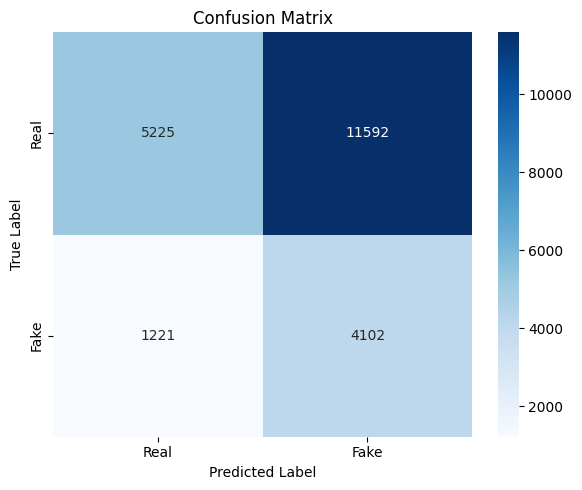

In [ ]:
acc = accuracy_score(labels, predictions)
print(f"Accuracy: {acc:.4f}\n")

print("Classification Report:")
print(classification_report(labels, predictions, target_names=['Real', 'Fake']))

cm = confusion_matrix(labels, predictions)
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()